# AMSC698K Homework 11
##### Elijah Kin

In [1]:
import json, os, qiskit, random, warnings
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np

from PIL import Image
from qiskit import transpile, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import Aer
from qiskit.circuit.library import Initialize
from qiskit_ionq import IonQProvider
from qiskit.quantum_info import Operator
from qiskit.visualization import array_to_latex, plot_histogram

In [2]:
print(qiskit.__version__)
token = os.getenv('IONQ_API_KEY')
warnings.filterwarnings('ignore', category=RuntimeWarning)

1.3.2


### Problem A
Notebook `QHED_intro.ipynb` introduces a quantum algorithm to extract color boundaries (edges) in images. The 256x256-pixel gray-tone picture at the end (`qhed_image.jpg`) features strong contours, which are easy to identify.

1. Identify the edges in this picture using a classical and a quantum technique. If your laptop doesn't enough RAM, you might need to divide the image into 4 sub-images, analyze each of them, and add the results to yield the edge image.

In [3]:
# Define decrement gate (amplitude permutation gate)
def Dgate(nqubits):
    circ = QuantumCircuit(nqubits)
    for k in reversed(range(1, nqubits)):
        ctrl = "0"*k
        circ.mcx(list(range(k)), k, ctrl_state=ctrl)
    circ.x(0)
    return circ

# Plot the image using matplotlib
def plot_image(img, title=None, ax=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots(1, 1, **kwargs)
    ax.imshow(img, extent=[0, img.shape[0], img.shape[1], 0], cmap='viridis')
    ticks_cnt = img.shape[0] // 8 if img.shape[0] > 8 else 1
    ax.set_xticks(range(0, img.shape[0] + 1, ticks_cnt))
    ax.set_yticks(range(0, img.shape[1] + 1, ticks_cnt))
    if title is not None:
        ax.set_title(title)

Raw Image info: (256, 256, 3)
Raw Image datatype: uint8


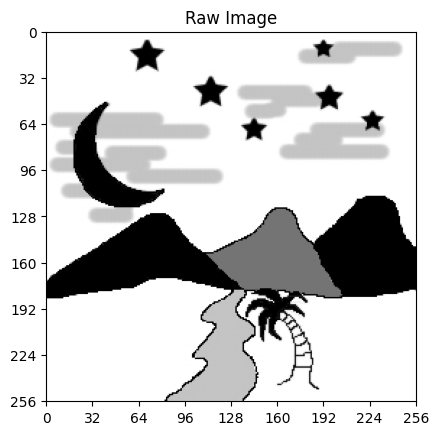

In [4]:
# Load the image from filesystem
image_raw = np.array(Image.open('qhed_image.jpg'))
print('Raw Image info:', image_raw.shape)
print('Raw Image datatype:', image_raw.dtype)

# Convert the RBG component of the image to B&W image (dtype=uint8)
image = image_raw[:,:,0] / 255

# Display the image
plot_image(image_raw, "Raw Image")

In [ ]:
# Convert the raw pixel values to probability amplitudes
def amplitude_encode(img_data):
    # Calculate the RMS value
    rms = np.sqrt(np.sum(img_data.flatten()**2))

    # Return flattened normalized image
    return img_data.flatten() / rms

# Get amplitude ancoded pixel values
# (a) horizontal
image_norm_h = amplitude_encode(image)

# (b) vertical
image_norm_v = amplitude_encode(image.T)

In [ ]:
# Number of qubits
nq_image = int(np.ceil(np.log2(image.size)))
qr = QuantumRegister(nq_image + 1, name="q")
q_aux = qr[0]
print("Image size:", image.shape, " -> number of qubits:", nq_image)

# Create the circuit for horizontal scan
qc_h = QuantumCircuit(qr)
qc_h.initialize(image_norm_h, qr[1:])
qc_h.h(q_aux)
qc_h.compose(Dgate(nq_image + 1), qr, inplace=True)
qc_h.h(q_aux)
qc_h.save_statevector()
qc_h.measure_all()

# Create the circuit for vertical scan
qc_v = QuantumCircuit(qr)
qc_v.initialize(image_norm_v, qr[1:])
qc_v.h(q_aux)
qc_v.compose(Dgate(nq_image + 1), qr, inplace=True)
qc_v.h(q_aux)
qc_v.save_statevector()
qc_v.measure_all()

circ_list = [qc_h, qc_v]

Image size: (256, 256)  -> number of qubits: 16


In [ ]:
def postprocess(results):
  statevec_h = results.get_statevector(qc_h)
  statevec_v = results.get_statevector(qc_v)

  print('Horizontal scan statevector:')
  display(array_to_latex(statevec_h, max_size=60))
  print('\nVertical scan statevector:')
  display(array_to_latex(statevec_v, max_size=60))

  # Select odd states from the raw statevector and reshape to 8x8 matrix
  ampl_h_odd = np.array([ statevec_h[2*i+1].real for i in range(2**nq_image) ]).reshape(image.shape)
  ampl_v_odd = np.array([ statevec_v[2*i+1].real for i in range(2**nq_image) ]).reshape(image.shape).T
  # Convert to binary values for plots
  edge_scan_h = np.where(np.abs(ampl_h_odd)>1e-9, 1, 0)
  edge_scan_v = np.where(np.abs(ampl_v_odd)>1e-9, 1, 0)

  # Plotting the Horizontal and vertical scans
  fig, ax = plt.subplots(1,2, figsize=(12,6))
  plot_image(edge_scan_h, 'Horizontal scan output', ax=ax[0])
  plot_image(edge_scan_v, 'Vertical scan output', ax=ax[1])
  plt.show()
  fig, ax = plt.subplots(1,2, figsize=(12,6))
  edge_scan = edge_scan_h | edge_scan_v
  plot_image(image, "Original image", ax=ax[0])
  plot_image(edge_scan, "Edge scan", ax=ax[1])

Horizontal scan statevector:


<IPython.core.display.Latex object>


Vertical scan statevector:


<IPython.core.display.Latex object>

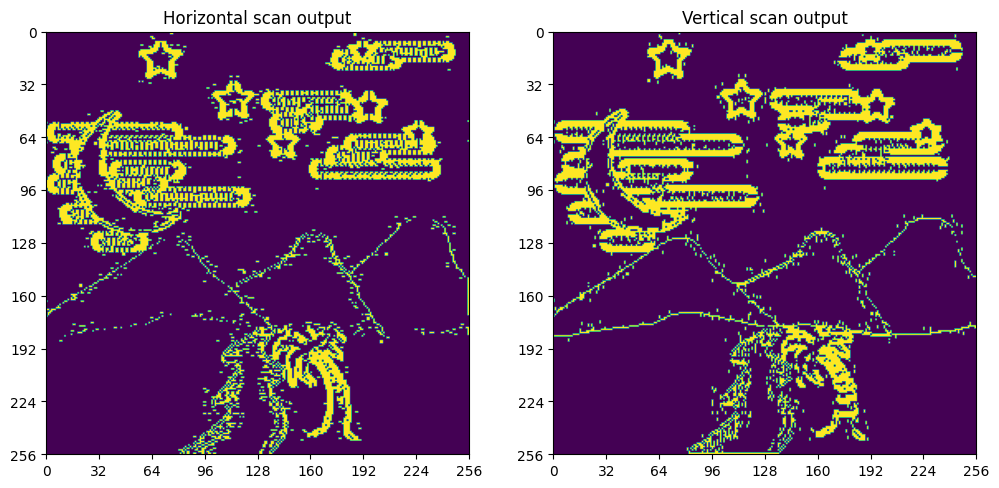

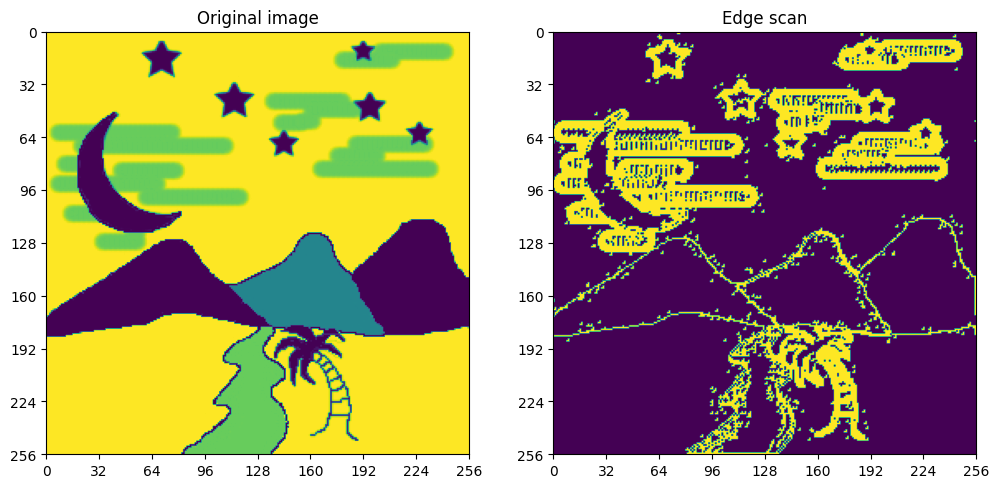

In [8]:
# Simulating the cirucits
backend = Aer.get_backend('aer_simulator')
results = backend.run(circ_list).result()
postprocess(results)

2. Run your quantum circuit on "ionq_simulator" with noise-model "forte-1", adjust thresholds (tolerances) if necessary, and submit the code to "ionq_qpu.forte-1".

In [9]:
provider = IonQProvider(token=token)
noisy_backend = provider.get_backend('ionq_simulator')
noisy_backend.set_options(noise_model='forte-1')

In [ ]:
# TODO
transpiled_circ_list = transpile(circ_list, noisy_backend, optimization_level=2)

In [ ]:
# TODO
results = noisy_backend.run(transpiled_circ_list).result()
postprocess(results)

### Problem B
1. Notebook `FER_intro.ipynb` contains a simple code to perform an analysis of facial expressions. The routine "faces_classifier" simply compares a test image with one random example of the "happy face" subset and one of the "sad face" subset. Find more reliable ways to classify a random test image. (You may modify the quantum circuit if desired.)

In [10]:
%%capture
!unzip ffhq_subset.zip

In [ ]:
# Load all images in the given folder (the image filename is a five digits code)
# Returns a list of dictionaries with keys: "image", "label", "landmarks"
def load_images_in_folder(folder, label):
    mylist = []
    images = filter(lambda f: f.endswith('.png'), os.listdir(folder))
    # For each png file:
    for filename in images:
        # Get the id, which is the filename without extension
        id = os.path.splitext(filename)[0]
        landmarks_file = f"{folder}/{int(id):05d}_landmarks.json"
        # Add the current item into the container
        mylist.append({ "image": f"{folder}/{filename}", "label": label,
            "landmarks": json.load(open(landmarks_file)) })
    return mylist

# Show image with overlaid landmark points in red
def show_image(face, ax=None):
    image = mpimg.imread(face["image"])
    x, y = zip(*face["landmarks"]) # divide the list of (x,y) tuple in the list of x's and y's
    if ax is None:
        fig,ax = plt.subplots(1,1,figsize=(8, 6), dpi=80) # set width of figure
    ax.imshow(image) # show image
    ax.scatter(x, y, color='red') # overlay the landmark points in red over the image

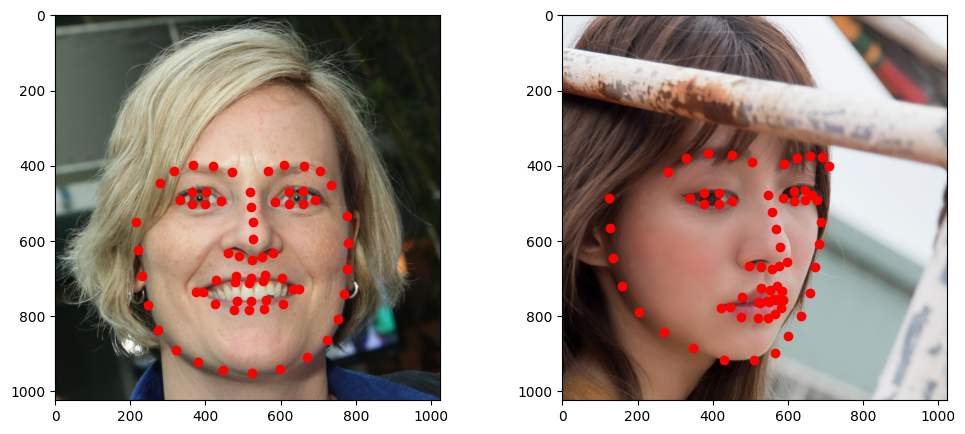

In [12]:
path_to_ffhq_folder = "FFHQ"
faces_dataset = []
faces_dataset += load_images_in_folder(os.path.join(path_to_ffhq_folder, "happy"), "HAPPY")
faces_dataset += load_images_in_folder(os.path.join(path_to_ffhq_folder, "sad"), "SAD")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
show_image(faces_dataset[2], ax=axes[0])
show_image(faces_dataset[10], ax=axes[1])

In [ ]:
def build_complete_graph(coordinates, triu_vector=False):
    """Given a list of N items in form (x,y), return the N*N matrix or
    (N-1)*(N-2)-dim vector representing the weighted undirected graph whose vertices
    are the points and edges between each pair of points weighted by distance between them"""

    N = len(coordinates)
    graph = np.zeros((N,N))
    # For each couple of points calculate the distance
    for i, coord_i in enumerate(coordinates):
        for j, coord_j in enumerate(coordinates):
            distance = np.linalg.norm(np.asarray(coord_i) - np.asarray(coord_j))
            graph[i][j] = distance
            graph[j][i] = distance
    if triu_vector:
        return graph[np.triu_indices(N, k=1)] # k=1 removes the diagonal
    return graph

def build_chordal_graph(coordinates, triu_vector=False):
    """Given a list of N items in form (x,y), return the N*N matrix representing
    the weighted undirected graph whose vertices are the points, an edge exists
    between the couple of points decided by the Delaunay triangulation procedure,
    and is labelled with the distance between them"""

    N = len(coordinates)
    graph = np.zeros((N, N))
    x, y = zip(*coordinates) # split (x,y) into array of x's and array of y's
    triang = tri.Triangulation(x, y) # calculate Delaunay triangulation
    # For each edge decided by the Delaunay triangulation procedure
    for edge in triang.edges:
        i, j = edge[0], edge[1]
        coord_i, coord_j = coordinates[i], coordinates[j]
        distance = np.linalg.norm(np.asarray(coord_i) - np.asarray(coord_j))
        graph[i][j] = distance
        graph[j][i] = distance
    if triu_vector:
        return graph[np.triu_indices(N, k=1)] # k=1 removes the diagonal
    return graph

In [ ]:
# Controlled circuit for initialization without leading Reset gates
def controlled_initialize(init_vector, control_qubits):

    initialize_circuit = Initialize(init_vector, normalize=True)
    # Gates_to_uncompute inverts the circuit and remove the Reset gatest
    initialize_circuit_wo_reset = initialize_circuit.gates_to_uncompute().inverse()

    # Return controlled version of the gate
    return initialize_circuit_wo_reset.control(control_qubits)

# Append zeros to complex vector until size 2**qubits is reached
def zero_padding(v_in, qubits):
    v_out = np.zeros((2**qubits,), dtype=np.cdouble)
    v_out[:len(v_in)] = v_in
    return v_out

# Circuit for classification: compares distances between G_test and G_happy, G_sad
def quantum_distance_circuit(G_test, G_happy, G_sad):

    # Qubits are needed for the data register and zero padding of graph vectors
    nqubits_features = int(np.ceil(np.log2(len(G_happy))))
    x_test = zero_padding(G_test, nqubits_features)
    x_0 = zero_padding(G_happy, nqubits_features)
    x_1 = zero_padding(G_sad, nqubits_features)

    # Define quantum and classical registers
    qr_aux = QuantumRegister(1, 'aux')
    qr_index = QuantumRegister(1, 'index')
    qr_data = QuantumRegister(nqubits_features, 'qr_data')
    qr_class = QuantumRegister(1, 'class')
    cr_aux = ClassicalRegister(1, 'cr_aux')
    cr_class = ClassicalRegister(1, 'cr_class')
    # Initialize the circuit
    qc = QuantumCircuit(qr_aux, qr_index, qr_data, qr_class, cr_aux, cr_class)
    # Initialize index and data registers
    qc.h([0, 1])
    qc.append(controlled_initialize(x_test, 1), [qr_aux[0]] + qr_data[:])
    qc.x(0)
    qc.append(controlled_initialize(x_0, 2), [qr_aux[0], qr_index[0]] + qr_data[:])
    qc.x(1)
    qc.append(controlled_initialize(x_1, 2), [qr_aux[0], qr_index[0]] + qr_data[:])
    # Correlate the index with the class and prepare qr_aux, qr_class for measurement
    qc.cx(qr_index[0], qr_class[0])
    qc.h(0)

    qc.measure(qr_aux[0], cr_aux[0])
    qc.measure(qr_class[0], cr_class[0])
    return qc

In [ ]:
# Optional argument 'tol' to classify equal distance within numerical accuracy
def classical_distance(G_test, G_happy, G_sad, tol=0.00001):

    # Distances between the test instance and the happy and sad instances
    distance_happy = np.linalg.norm(G_test - G_happy)
    distance_sad = np.linalg.norm(G_test - G_sad)

    # Difference = 0 if the distance is equal, > 0 if sad is closest, < 0 if happy is closest
    difference = distance_happy - distance_sad
    # Remove some numerical error to classify EQUAL and set sign = 1 -> SAD, sign = -1 -> HAPPY
    diff_sign = 0 if np.abs(difference) <= tol else int(np.sign(difference))

    return difference, ["EQUAL", "SAD", "HAPPY"][diff_sign]

# Optional arguments: 'tol' (see above) and 'backend', 'nshots' for sampling
def quantum_distance(G_test, G_happy, G_sad, tol=0.00001, backend=None, nshots=10000):

    qc = quantum_distance_circuit(G_test, G_happy, G_sad)
    # Custom backend or Aer_simulator
    if backend is None:
        backend = Aer.get_backend('aer_simulator')
    qc_t = transpile(qc, backend)
    sampled = backend.run(qc_t, shots=nshots).result().get_counts()
    # dictionary with all possible result keys
    counts = {'0 0' : 0, '0 1' : 0, '1 0' : 0, '1 1' : 0} # LSB = cr_aux, MSB = cr_class
    for k,v in sampled.items():
        counts[k] = v
    # calculate distance: keep only counts for either cr_aux=0 or opposite cr_aux=1
    take_aux_zero = False # may change to True
    if take_aux_zero:
        distance_happy = counts['1 0']
        distance_sad = counts['0 0']
    else:
        distance_happy = counts['0 1']
        distance_sad = counts['1 1']
    difference = (distance_happy - distance_sad) / nshots
    diff_sign = 0 if np.abs(difference) <= tol else int(np.sign(difference))
    return difference, ["EQUAL", "SAD", "HAPPY"][diff_sign]

In [ ]:
def faces_classifier(test_instance, happy_instance, sad_instance,
                     use_quantum=True, use_complete_graph=True,
                     n_points=20, backend=None, nshots=10000):
    # choose points
    if isinstance(n_points, (list,tuple, np.ndarray)):
        chosen_points = np.array(n_points)
    else:
        if not isinstance(n_points, int):
            n_points = 20
        chosen_points  = np.sort(np.random.choice(range(48, 68), n_points, replace=False))

    test_instance  = np.array(test_instance["landmarks"])[chosen_points]
    happy_instance = np.array(happy_instance["landmarks"])[chosen_points]
    sad_instance   = np.array(sad_instance["landmarks"])[chosen_points]

    # calculate features
    if use_complete_graph:
        feature_happy = build_complete_graph(happy_instance, triu_vector=True)
        feature_sad = build_complete_graph(sad_instance, triu_vector=True)
        feature_test = build_complete_graph(test_instance, triu_vector=True)
    else:
        feature_happy = build_chordal_graph(happy_instance, triu_vector=True)
        feature_sad = build_chordal_graph(sad_instance, triu_vector=True)
        feature_test = build_chordal_graph(test_instance, triu_vector=True)

    # classify
    if use_quantum:
        distance, label = quantum_distance(feature_test, feature_happy, feature_sad,
                                           backend=backend, nshots=nshots)
    else:
        distance, label = classical_distance(feature_test, feature_happy, feature_sad)
    return label

In [17]:
happy_dataset = load_images_in_folder(os.path.join(path_to_ffhq_folder, "happy"), "HAPPY")
sad_dataset = load_images_in_folder(os.path.join(path_to_ffhq_folder, "sad"), "SAD")

N_TRAINING_ITEMS = 5
happy_training_set = happy_dataset[:N_TRAINING_ITEMS]
sad_training_set = sad_dataset[:N_TRAINING_ITEMS]

happy_testing_set = happy_dataset[N_TRAINING_ITEMS:]
sad_testing_set = sad_dataset[N_TRAINING_ITEMS:]
testing_set = happy_testing_set + sad_testing_set

In [18]:
n_points = 15 # from 1 to 20
use_complete_graph = True
use_quantum = True
classifications_per_item = 3 # compare several instances of the same subset

correct, wrong = 0, 0
for test_instance in testing_set:

    labels = []
    for _ in range(classifications_per_item):
        happy_instance = random.choice(happy_training_set)
        sad_instance = random.choice(sad_training_set)
        label = faces_classifier(test_instance, happy_instance, sad_instance,
                                 use_quantum=use_quantum,
                                 use_complete_graph=use_complete_graph,
                                 n_points=n_points)
        labels.append(label)

    label = max(set(labels), key=labels.count)

    if label == test_instance["label"]:
        correct += 1
        print(".", end="")
    else:
        wrong += 1
        print("X", end="")

print(f"\nWe have classified {correct} faces correctly and {wrong} faces wrongly")

....X.....
We have classified 9 faces correctly and 1 faces wrongly


2. Explain how the quantum circuit (pictured in `FER_intro.ipynb`) performs the classification starting from the state $|0\rangle_{aux} |0\rangle_{index} |00\dots0\rangle_{data} |0\rangle_{class}$.

TODO